In [1]:
# load some necessary modules
from dmipy.core import modeling_framework
from os.path import join
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

/Users/paddyslator/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# from dmipy.hcp_interface import downloader_aws

# public_aws_key = 
# secret_aws_key =

# hcp_interface = downloader_aws.HCPInterface(
#    your_aws_public_key=public_aws_key,
#    your_aws_secret_key=secret_aws_key)

#hcp_interface.download_and_prepare_dmipy_example_dataset()

In [3]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


In [4]:
#ball and stick model
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
ballstick = MultiCompartmentModel(models=[stick, ball])

We highly recommend installing pathos to take advantage of multicore processing.


In [5]:
BAS_fit_hcp = ballstick.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)


Setup brute2fine optimizer in 1.7438058853149414 seconds
Fitting of 8181 voxels complete in 263.2659320831299 seconds.
Average of 0.03218016527113188 seconds per voxel.


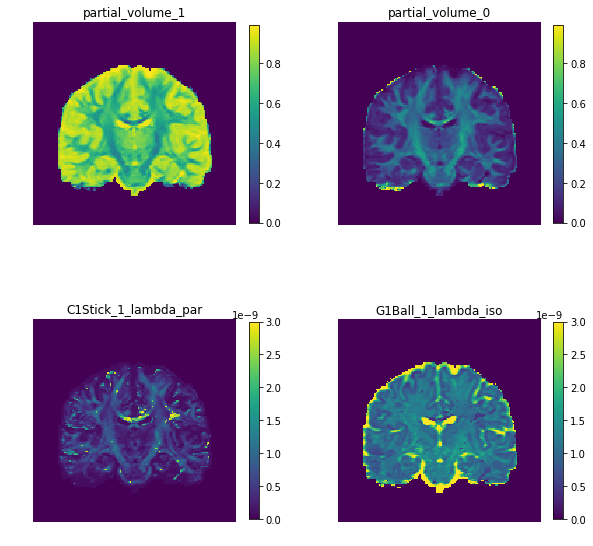

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fitted_parameters = BAS_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)
    counter += 1



In [7]:
print(np.shape(fitted_parameters['partial_volume_1']))
np.shape(np.ndarray.flatten(fitted_parameters['partial_volume_1']))

mask=data_hcp[..., 0]>0

np.shape(mask)

# initial voxel-wise estimates from LSQ fits within the mask
D0_init = fitted_parameters['C1Stick_1_lambda_par'][mask]
D1_init = fitted_parameters['G1Ball_1_lambda_iso'][mask]
f0_init = fitted_parameters['partial_volume_0'][mask]
f1_init = fitted_parameters['partial_volume_1'][mask]
stick_ori_init = fitted_parameters['C1Stick_1_mu'][mask]


# flatten params to get [5 x nvox] array
params_all = np.array([D0_init,
                       D1_init,
                       f0_init,
                       stick_ori_init[:,0],
                       stick_ori_init[:,1]])


(145, 1, 145)


In [8]:


nvox = np.shape(params_all)[1]



#get the initial E_sim, E_fit
dimx=nvox
dimy=1
nmeas = len(scheme_hcp.bvalues)

E_sim = np.zeros((dimx, dimy, nmeas))
E_sim[:,0,:] = data_hcp[mask]

E_fit = np.zeros((dimx, dimy, nmeas))
for x in range(0, dimx):
    for y in range(0,dimy):
        # generate signal
        parameter_vector = ballstick.parameters_to_parameter_vector(
            C1Stick_1_mu=stick_ori_init[x,:],
            C1Stick_1_lambda_par=D0_init[x],
            G1Ball_1_lambda_iso=D1_init[x],
            partial_volume_0=f0_init[x],
            partial_volume_1=1 - f0_init[x])
        E_fit[x, y, :] = ballstick.simulate_signal(scheme_hcp, parameter_vector)

In [9]:
import numpy as np
import scipy.stats
import copy
import matplotlib.pyplot as plt
import time
import math

# initialise sigma
sigma = np.cov(params_all)

# TO DO: tune weights for Metropolis-Hastings parameter sampling (f, D, D* from Orton, orientations guessed)
w = [.5e-10, .2e-10, .01, .01, .01]

nMCMCsteps = 5
#T = compute_temp_schedule(2000, 10**-3, nMCMCsteps)

#Accepted = 1
#Acceptance_rate = []
#Acceptance_rate.append(Accepted)

tmppar = np.zeros((nvox, nMCMCsteps, 5))
tmpgibbs = np.zeros((5, nMCMCsteps))

# NB i (voxel loop) and j (MC loop) in keeping with Orton paper
for j in range(0, nMCMCsteps):
    print(j)
    it = j+1
    # Gibbs moves to update priors
    # sample mu from multivariate normal distribution defined by current parameter estimates
    m = np.mean(params_all, axis=1)
    V = sigma / nvox
    mu = np.random.multivariate_normal(m, V)
    mu_scaled = mu * [1e9, 1e9, 1, 1, 1]

    # sample sigma from inverse Wishart distribution (using newly updated mu)
    # NB scaled parameters used in calculation of priors in Metropolis-Hastings updates
    phi = np.sum([np.outer(params_all[:, i]-mu,
                        params_all[:, i]-mu)
                for i in range(0, nvox)], axis=0)
    phi_scaled = np.sum([np.outer((params_all[:, i] - mu)*[1e9, 1e9, 1, 1, 1],
                                (params_all[:, i] - mu)*[1e9, 1e9, 1, 1, 1])
                        for i in range(0, nvox)], axis=0)
    sigma = scipy.stats.invwishart(scale=phi, df=nvox-5).rvs()
    sigma_scaled = scipy.stats.invwishart(scale=phi_scaled, df=nvox-5).rvs()

    # Metropolis-Hastings parameter updates
    params_all_new = copy.copy(params_all)
    for i in range(0, nvox):
        # TO DO: loop over parameters (Lizzie)
        for p in range(5):
            #p = 0  # for now just look at
            # sample parameter
            params_all_new[p, i] = np.random.normal(params_all[p, i], w[p])
            if i == 0:
                print([params_all_new[p, i], params_all[p, i]])
            # compute acceptance
            y_i = copy.copy(E_sim[i, ])                                                    # actual measured signal
            g_i = copy.copy(E_fit[i, ])                                                    # model-predicted signal (old params)
            parameter_vector = ballstick.parameters_to_parameter_vector(
                C1Stick_1_mu=[params_all_new[3, i], params_all_new[4, i]],
                C1Stick_1_lambda_par=params_all_new[0, i],
                G1Ball_1_lambda_iso=params_all_new[1, i],
                partial_volume_0=params_all_new[2, i],
                partial_volume_1=1-params_all_new[2, i])
            g_i_new = ballstick.simulate_signal(scheme_hcp, parameter_vector)   # model-predicted signal (new params)
            # calculate posteriors and PDFs (log scale)
            likelihood = (-nmeas / 2) * np.log(np.inner(y_i, y_i) -
                                            ((np.inner(y_i, g_i)) ** 2 / np.inner(g_i, g_i)))
            likelihood_new = (-nmeas / 2) * np.log(np.inner(y_i, y_i) -
                                                (np.inner(y_i, g_i_new) ** 2 / np.inner(g_i_new, g_i_new)))

            if p <= 2:  # non-orientation parameters
                # both priors are the same without scaling
                prior = np.log(scipy.stats.multivariate_normal.pdf(params_all[:, i], mu, sigma, allow_singular=1))
                prior_new = np.log(scipy.stats.multivariate_normal.pdf(params_all_new[:, i], mu, sigma, allow_singular=1))
                # scaling parameters helps
                prior_scaled = np.log(scipy.stats.multivariate_normal.pdf(params_all[:, i] * [1e9, 1e9, 1, 1, 1],
                                                                        mu_scaled, sigma_scaled, allow_singular=1))
                prior_new_scaled = np.log(scipy.stats.multivariate_normal.pdf(params_all_new[:, i] * [1e9, 1e9, 1, 1, 1],
                                                                            mu_scaled, sigma_scaled, allow_singular=1))
            else:  # orientation parameters (Chris to modify) (scaling here?)
                prior = 1
                prior_new = 1
                prior_scaled = 1
                prior_new_scaled = 1

            alpha = np.min([0, (likelihood_new + prior_new) - (likelihood + prior)])
            alpha_scaled = np.min([0, (likelihood_new + prior_new_scaled) - (likelihood + prior_scaled)] )
            r = np.log(np.random.uniform(0, 1))

            # reject new parameter value if criteria not met
            if r < alpha_scaled:
                #Accepted +=1
                params_all[p, i] = copy.copy(params_all_new[p, i])
                E_fit[i, ] = copy.copy(g_i_new)
            # else:
            #     if Accepted/(it*nvox) < 0.23:
            #         continue
                    # print("Stopping criterion met {}".format(Accepted/(it*nvox)))
                    # return Acceptance_rate

            # for plotting
            tmppar[i, j, p] = copy.copy(params_all[p, i])
            tmpgibbs[:, j] = mu

            #Acceptance_rate.append(Accepted/(it*nvox) )

0
[6.550280798509706e-11, 1.0000000000000002e-10]
[2.6802786912894484e-09, 2.666782647011921e-09]
[0.35006348449798774, 0.34649452459834906]
[2.0312672917467522, 2.036426920609204]
[-0.00393680706087658, 0.014815795885011395]
1
[2.6497269529538752e-11, 6.550280798509706e-11]
[2.6577148321306813e-09, 2.6802786912894484e-09]
[0.349089005808692, 0.35006348449798774]
[2.027888315569886, 2.0312672917467522]
[0.0026763863211176023, -0.00393680706087658]
2
[1.1727535379019849e-10, 2.6497269529538752e-11]
[2.6586907848407377e-09, 2.6577148321306813e-09]
[0.3433175421741299, 0.349089005808692]
[2.0445742731015604, 2.027888315569886]
[0.014295885413269831, 0.0026763863211176023]
3
[-7.315944578722723e-12, 2.6497269529538752e-11]
[2.6187273725655666e-09, 2.6577148321306813e-09]
[0.33236052198805255, 0.349089005808692]
[2.0132753708158124, 2.027888315569886]
[0.01860107969444879, 0.0026763863211176023]
4
[5.834533799213066e-11, -7.315944578722723e-12]
[2.601645750008904e-09, 2.6187273725655666e-09

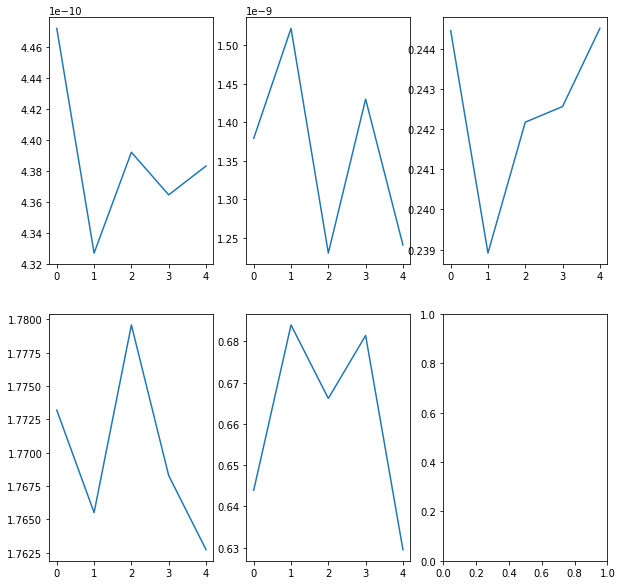

In [10]:
fig, axs = plt.subplots(2, 3, figsize=[10, 10])
axs = axs.ravel()

for i in range(0,5):
    axs[i].plot(tmpgibbs[i,:])
    

In [11]:
print(sigma)
print(mu)

[[ 1.53708771e-19 -7.62174179e-20  2.21920929e-11  4.10246379e-11
  -9.16761245e-11]
 [-7.62174179e-20  3.62976412e-19 -1.04410157e-11 -1.68143776e-11
   1.12321650e-10]
 [ 2.21920929e-11 -1.04410157e-11  2.21019483e-02  2.80828204e-02
  -6.96940131e-02]
 [ 4.10246379e-11 -1.68143776e-11  2.80828204e-02  4.90927483e-01
  -5.83450385e-02]
 [-9.16761245e-11  1.12321650e-10 -6.96940131e-02 -5.83450385e-02
   3.21995859e+00]]
[4.38330952e-10 1.24059460e-09 2.44502083e-01 1.76272770e+00
 6.29541838e-01]


In [12]:
fitted_parameters.keys()

dict_keys(['partial_volume_1', 'C1Stick_1_mu', 'partial_volume_0', 'C1Stick_1_lambda_par', 'G1Ball_1_lambda_iso'])

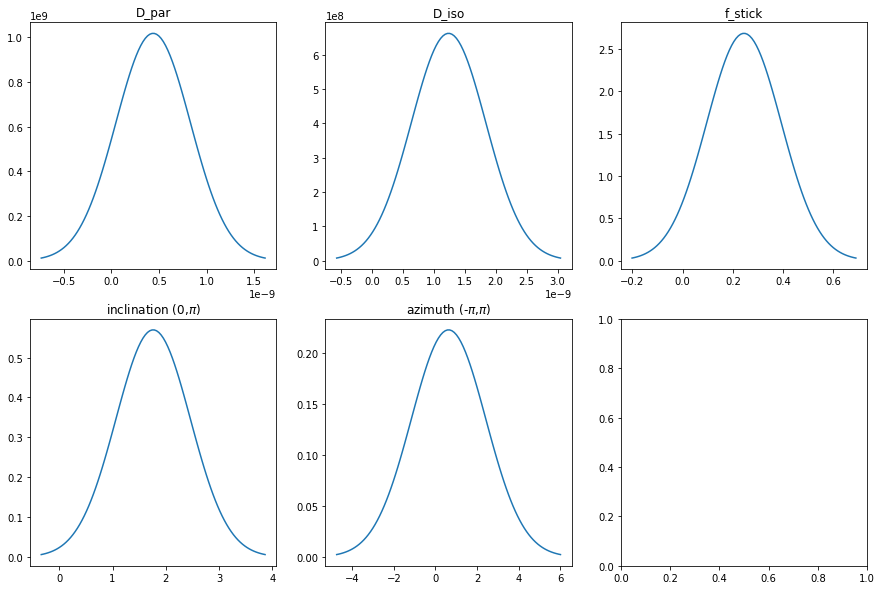

In [13]:
import scipy.stats as stats

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

names = ['D_par','D_iso','f_stick','inclination (0,$\pi$)','azimuth (-$\pi$,$\pi$)']


for i in range(0,5):
    marginal_mu = mu[i]
    variance = sigma[i,i]
    marginal_sigma = math.sqrt(variance)
    x = np.linspace(marginal_mu - 3*marginal_sigma, marginal_mu + 3*marginal_sigma, 100)
    axs[i].plot(x, stats.norm.pdf(x, marginal_mu, marginal_sigma))
    axs[i].set_title(names[i])
 

In [14]:
x

array([-4.75373108, -4.64497809, -4.5362251 , -4.42747211, -4.31871913,
       -4.20996614, -4.10121315, -3.99246016, -3.88370717, -3.77495419,
       -3.6662012 , -3.55744821, -3.44869522, -3.33994223, -3.23118924,
       -3.12243626, -3.01368327, -2.90493028, -2.79617729, -2.6874243 ,
       -2.57867131, -2.46991833, -2.36116534, -2.25241235, -2.14365936,
       -2.03490637, -1.92615339, -1.8174004 , -1.70864741, -1.59989442,
       -1.49114143, -1.38238844, -1.27363546, -1.16488247, -1.05612948,
       -0.94737649, -0.8386235 , -0.72987052, -0.62111753, -0.51236454,
       -0.40361155, -0.29485856, -0.18610557, -0.07735259,  0.0314004 ,
        0.14015339,  0.24890638,  0.35765937,  0.46641236,  0.57516534,
        0.68391833,  0.79267132,  0.90142431,  1.0101773 ,  1.11893028,
        1.22768327,  1.33643626,  1.44518925,  1.55394224,  1.66269523,
        1.77144821,  1.8802012 ,  1.98895419,  2.09770718,  2.20646017,
        2.31521316,  2.42396614,  2.53271913,  2.64147212,  2.75

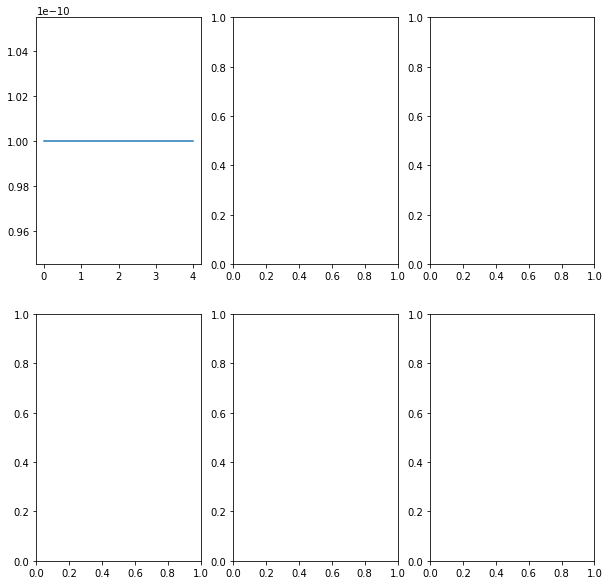

In [15]:
fig, axs = plt.subplots(2, 3, figsize=[10, 10])
axs = axs.ravel()

axs[0].plot(tmppar[3000,:,0])

In [16]:
D0_fitted = np.zeros(np.shape(mask))
D1_fitted = np.zeros(np.shape(mask))
f0_fitted = np.zeros(np.shape(mask))
f1_fitted = np.zeros(np.shape(mask))
                                  
D0_fitted[mask] = params_all[0,:]
D1_fitted[mask] = params_all[1,:]
f0_fitted[mask] = params_all[2,:]
f1_fitted[mask] = 1 - params_all[2,:]

D0_fitted = np.flip(D0_fitted.transpose(2,1,0),0)
D1_fitted = np.flip(D1_fitted.transpose(2,1,0),0)
f0_fitted = np.flip(f0_fitted.transpose(2,1,0),0)
f1_fitted = np.flip(f1_fitted.transpose(2,1,0),0)


D0_LSQ = BAS_fit_hcp.fitted_parameters['G1Ball_1_lambda_iso'][:,0,:]
D0_LSQ = np.flip(D0_LSQ.transpose(1,0),0)

D1_LSQ = BAS_fit_hcp.fitted_parameters['C1Stick_1_lambda_par'][:,0,:]
D1_LSQ = np.flip(D1_LSQ.transpose(1,0),0)

f0_LSQ = BAS_fit_hcp.fitted_parameters['partial_volume_0'][:,0,:]
f0_LSQ = np.flip(f0_LSQ.transpose(1,0),0)
    
f1_LSQ = BAS_fit_hcp.fitted_parameters['partial_volume_1'][:,0,:]
f1_LSQ = np.flip(f1_LSQ.transpose(1,0),0)    


Text(0.5,1,'f_1')

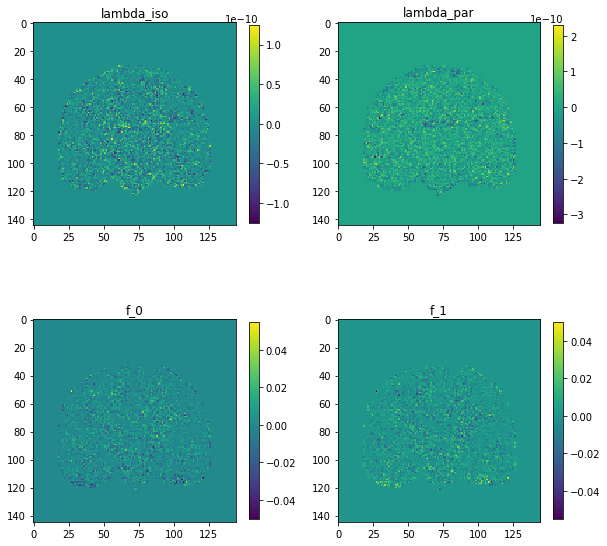

In [17]:
fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

colormap=axs[0].imshow(D1_fitted[:,0,:] - D0_LSQ)
fig.colorbar(colormap, ax=axs[0], shrink=0.8)
axs[0].set_title('lambda_iso')

colormap=axs[1].imshow(D0_fitted[:,0,:] - D1_LSQ)
fig.colorbar(colormap, ax=axs[1], shrink=0.8)
axs[1].set_title('lambda_par')

colormap=axs[2].imshow(f0_fitted[:,0,:] - f0_LSQ)
fig.colorbar(colormap, ax=axs[2], shrink=0.8)
axs[2].set_title('f_0')

colormap=axs[3].imshow(f1_fitted[:,0,:] - f1_LSQ)
fig.colorbar(colormap, ax=axs[3], shrink=0.8)
axs[3].set_title('f_1')


Text(0.5,1,'f_1')

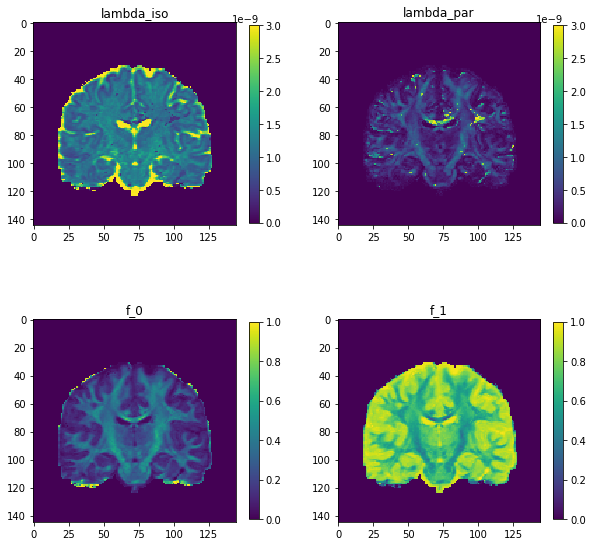

In [18]:
fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

colormap=axs[0].imshow(D1_fitted[:,0,:],vmin=0, vmax=3e-9)
fig.colorbar(colormap, ax=axs[0], shrink=0.8)
axs[0].set_title('lambda_iso')

colormap=axs[1].imshow(D0_fitted[:,0,:],vmin=0, vmax=3e-9)
fig.colorbar(colormap, ax=axs[1], shrink=0.8)
axs[1].set_title('lambda_par')

colormap=axs[2].imshow(f0_fitted[:,0,:],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[2], shrink=0.8)
axs[2].set_title('f_0')

colormap=axs[3].imshow(f1_fitted[:,0,:],vmin=0, vmax=1)
fig.colorbar(colormap, ax=axs[3], shrink=0.8)
axs[3].set_title('f_1')


In [19]:
BAS_fit_hcp.fitted_parameters.keys()

dict_keys(['partial_volume_1', 'C1Stick_1_mu', 'partial_volume_0', 'C1Stick_1_lambda_par', 'G1Ball_1_lambda_iso'])

In [20]:
print(np.shape(f0_fitted[:,0,:])) 
print(np.shape(BAS_fit_hcp.fitted_parameters['partial_volume_0'][:,0,:]))

(145, 145)
(145, 145)


In [21]:
fitted_parameters

{'C1Stick_1_lambda_par': array([[[0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.]]]), 'C1Stick_1_mu': array([[[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],
 
 
        [[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],
 
 
        [[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],
 
 
        ...,
 
 
        [[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],
 
 
        [[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0